In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import xarray as xr
import sys
import os
from re import split
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import seaborn as sns
import dask.dataframe as dd
import pylab
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.style.use('seaborn')

In [2]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       scheduler_options={'host': '172.22.179.3:7227', 'dashboard_address': ':7798'})

In [3]:
# cluster.scale(2)
cluster.adapt(maximum_jobs=4)
cluster

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7798/status,
Dashboard: http://172.22.179.3:7798/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7227,Workers: 0
Dashboard: http://172.22.179.3:7798/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())


In [6]:
df = pd.read_csv('../results/all_filtered_202111111947.csv')
df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df['time'] = pd.to_datetime(df.time)
df.index = df.time
df.drop(columns='time', inplace=True)
times = list(df.index)
len(times)

11366

In [7]:
ds_vel = ds_xr[['vel14', 'vel35', 'vel95s']].sel(time=times).where(ds_xr.alt3d > 500)


In [8]:
ds_xr_2 = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAsWs/lores.zarr')
ds_xr_2 = ds_xr_2.sel(time=~ds_xr_2.get_index("time").duplicated())

In [9]:
df_2 = pd.read_csv('../results/all_filtered_202111190906_Wn_zhh14.csv')
print(df_2.shape)
df_2.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df_2['time'] = pd.to_datetime(df_2.time)
df_2.index = df_2.time
df_2.drop(columns='time', inplace=True)
times_2 = df_2.index


(13969, 918)


In [10]:
ds_vel_2 = ds_xr_2[['vel14', 'vel35', 'vel95s']].sel(time=times_2).where(ds_xr_2.alt3d > 500)

In [11]:
a = ds_vel.groupby("time.dayofyear")
b = ds_vel_2.groupby("time.dayofyear")

In [12]:
ls_14_a = []
ls_35_a = []
ls_95_a = []
for i, gr in enumerate(a):
    df_vel14 = gr[1][['vel14']].to_dataframe().assign(Location=1)
    df_vel35 = gr[1][['vel35']].to_dataframe().assign(Location=2)
    df_vel95 = gr[1][['vel95s']].to_dataframe().assign(Location=3)
    day = pd.to_datetime(pd.to_datetime(gr[1].time[0].values).strftime('%Y-%m-%d'))
    dict_fl = {day: f'RF{i + 1:02d}'}
    df_vel14['day'] = day
    df_vel35['day'] = day
    df_vel95['day'] = day
    df_vel14['vuelo'] = df_vel14['day'].map(dict_fl)
    df_vel35['vuelo'] = df_vel35['day'].map(dict_fl)
    df_vel95['vuelo'] = df_vel95['day'].map(dict_fl)
    ls_14_a.append(df_vel14)
    ls_35_a.append(df_vel35)
    ls_95_a.append(df_vel95)


In [13]:
ls_14_b = []
ls_35_b = []
ls_95_b = []
for i, gr in enumerate(b):
    df_vel14 = gr[1][['vel14']].to_dataframe().assign(Location=1)
    df_vel35 = gr[1][['vel35']].to_dataframe().assign(Location=2)
    df_vel95 = gr[1][['vel95s']].to_dataframe().assign(Location=3)
    dict_fl = {day: f'RF{i + 1:02d}'}
    df_vel14['day'] = day
    df_vel35['day'] = day
    df_vel95['day'] = day
    df_vel14['vuelo'] = df_vel14['day'].map(dict_fl)
    df_vel35['vuelo'] = df_vel35['day'].map(dict_fl)
    df_vel95['vuelo'] = df_vel95['day'].map(dict_fl)
    ls_14_b.append(df_vel14)
    ls_35_b.append(df_vel35)
    ls_95_b.append(df_vel95)


In [14]:
df_14 = pd.concat(ls_14_a + ls_14_b)
df_14 = df_14[(df_14.vel14 > -10 ) & (df_14.vel14 < 15)]
df_14 = df_14.rename(columns={'vel14': 'vel'})

In [15]:
updraft_percentiles = df_14[df_14.vel > 1].groupby('vuelo').vel.quantile([.3,.5,.7,.9])
downdraft_percentiles = df_14[df_14.vel < -1].groupby('vuelo').vel.quantile([.3,.5,.7,.9])

In [16]:
updraft_percentiles

vuelo     
RF01   0.3     3.387796
       0.5     5.542378
       0.7     8.709592
       0.9    12.769639
RF02   0.3     3.467700
                ...    
RF23   0.9    12.348515
RF24   0.3     3.280860
       0.5     4.861798
       0.7     6.911477
       0.9    10.407323
Name: vel, Length: 96, dtype: float64

In [17]:
df_35 = pd.concat(ls_35_a + ls_35_b)
df_35 = df_35[(df_35.vel35 > -10 ) & (df_35.vel35 < 15)]
df_35 = df_35.rename(columns={'vel35': 'vel'})

In [18]:
df_95 = pd.concat(ls_95_a + ls_95_b)
# df_95 = df_95[(df_95.vel95s > -10 ) & (df_95.vel95s < 15)]
df_95 = df_95.rename(columns={'vel95s': 'vel'})

In [19]:
df_95 = df_95[(df_95.vel > -10 ) & (df_95.vel < 15)]
df_95

vel        alt3d  \
range cross_track time                                                
90    0           2019-09-14 03:22:48.249800  0.000009  5640.674512   
                  2019-09-14 03:22:50.099800 -0.028120  5640.598891   
                  2019-09-14 03:22:51.949800 -0.008230  5640.599655   
                  2019-09-14 03:22:53.799800  0.003994  5640.321498   
                  2019-09-14 03:22:55.649800 -0.003186  5639.624998   
...                                                ...          ...   
376   22          2019-10-05 06:30:25.799800  1.350201   586.030454   
                  2019-10-05 06:30:29.499800  0.346646   511.742447   
      23          2019-10-05 06:30:33.199800  1.070489   759.126901   
      24          2019-10-05 06:30:29.499800  0.305345   954.826000   
                  2019-10-05 06:30:31.349800  1.246147  1035.905733   

                                                  lat3d       lon3d  Location  \
range cross_track time                                                          
90    0           2019-09-14 03:22:48.249800  15.072784  121.586024         3   
                  2019-09-14 03:22:50.099800  15.075315  121.584682         3   
                  2019-09-14 03:22:51.949800  15.077846  121.583343         3   
                  2019-09-14 03:22:53.799800  15.080374  121.582012         3   
                  2019-09-14 03:22:55.649800  15.082917  121.580678         3   
...                                                 ...         ...       ...   
376   22          2019-10-05 06:30:25.799800  16.934059  124.263909         3   
                  2019-10-05 06:30:29.499800  16.927906  124.262198         3   
      23          2019-10-05 06:30:33.199800  16.920035  124.257157         3   
      24          2019-10-05 06:30:29.499800  16.929115  124.258132         3   
                  2019-10-05 06:30:31.349800  16.924485  124.255856         3   

                                                    day vuelo  
range cross_track time                                         
90    0           2019-09-14 03:22:48.249800 2019-10-05  RF01  
                  2019-09-14 03:22:50.099800 2019-10-05  RF01  
                  2019-09-14 03:22:51.949800 2019-10-05  RF01  
                  2019-09-14 03:22:53.799800 2019-10-05  RF01  
                  2019-09-14 03:22:55.649800 2019-10-05  RF01  
...                                                 ...   ...  
376   22          2019-10-05 06:30:25.799800 2019-10-05  RF12  
                  2019-10-05 06:30:29.499800 2019-10-05  RF12  
      23          2019-10-05 06:30:33.199800 2019-10-05  RF12  
      24          2019-10-05 06:30:29.499800 2019-10-05  RF12  
                  2019-10-05 06:30:31.349800 2019-10-05  RF12  

[13472477 rows x 7 columns]

In [20]:
df_95

vel        alt3d  \
range cross_track time                                                
90    0           2019-09-14 03:22:48.249800  0.000009  5640.674512   
                  2019-09-14 03:22:50.099800 -0.028120  5640.598891   
                  2019-09-14 03:22:51.949800 -0.008230  5640.599655   
                  2019-09-14 03:22:53.799800  0.003994  5640.321498   
                  2019-09-14 03:22:55.649800 -0.003186  5639.624998   
...                                                ...          ...   
376   22          2019-10-05 06:30:25.799800  1.350201   586.030454   
                  2019-10-05 06:30:29.499800  0.346646   511.742447   
      23          2019-10-05 06:30:33.199800  1.070489   759.126901   
      24          2019-10-05 06:30:29.499800  0.305345   954.826000   
                  2019-10-05 06:30:31.349800  1.246147  1035.905733   

                                                  lat3d       lon3d  Location  \
range cross_track time                                                          
90    0           2019-09-14 03:22:48.249800  15.072784  121.586024         3   
                  2019-09-14 03:22:50.099800  15.075315  121.584682         3   
                  2019-09-14 03:22:51.949800  15.077846  121.583343         3   
                  2019-09-14 03:22:53.799800  15.080374  121.582012         3   
                  2019-09-14 03:22:55.649800  15.082917  121.580678         3   
...                                                 ...         ...       ...   
376   22          2019-10-05 06:30:25.799800  16.934059  124.263909         3   
                  2019-10-05 06:30:29.499800  16.927906  124.262198         3   
      23          2019-10-05 06:30:33.199800  16.920035  124.257157         3   
      24          2019-10-05 06:30:29.499800  16.929115  124.258132         3   
                  2019-10-05 06:30:31.349800  16.924485  124.255856         3   

                                                    day vuelo  
range cross_track time                                         
90    0           2019-09-14 03:22:48.249800 2019-10-05  RF01  
                  2019-09-14 03:22:50.099800 2019-10-05  RF01  
                  2019-09-14 03:22:51.949800 2019-10-05  RF01  
                  2019-09-14 03:22:53.799800 2019-10-05  RF01  
                  2019-09-14 03:22:55.649800 2019-10-05  RF01  
...                                                 ...   ...  
376   22          2019-10-05 06:30:25.799800 2019-10-05  RF12  
                  2019-10-05 06:30:29.499800 2019-10-05  RF12  
      23          2019-10-05 06:30:33.199800 2019-10-05  RF12  
      24          2019-10-05 06:30:29.499800 2019-10-05  RF12  
                  2019-10-05 06:30:31.349800 2019-10-05  RF12  

[13472477 rows x 7 columns]

In [21]:
df_95.groupby('day', as_index=False).mean()

,day,vel,alt3d,lat3d,lon3d,Location
0,2019-10-05,-0.040102,3070.157093,15.587046,123.168503,3.0


In [22]:
df_all = pd.concat([df_14, df_35, df_95])

In [23]:
# df_all.to_csv('../results/df_filtered/velocities_all.csv')

In [24]:
zhh14 = pd.read_csv('../results/df_filtered/zhh14_merged_Wn_Ws.csv')
zhh14['time'] = pd.to_datetime(zhh14.time)
zhh14.index = zhh14.time
zhh14.drop(columns='time', inplace=True)
zhh14 = zhh14.assign(Location=1)

In [25]:
df_day = zhh14.groupby(zhh14.index.floor('d'))
flights = list(df_day.groups.keys())
dict_flights = {f'RF{i + 1:02d}':flights[i] for i in range(len(flights)) }
dict_fl = {flights[i]:f'RF{i + 1:02d}' for i in range(len(flights)) }

In [26]:
zhh35 = pd.read_csv('../results/df_filtered/zhh35_merged_Wn_Ws.csv')
zhh35['time'] = pd.to_datetime(zhh35.time)
zhh35.index = zhh35.time
zhh35.drop(columns='time', inplace=True)
zhh35 = zhh35.assign(Location=2)

In [27]:
zhh95 = pd.read_csv('../results/df_filtered/zhh95.csv')
zhh95['time'] = pd.to_datetime(zhh95.time)
zhh95.index = zhh95.time
zhh95.drop(columns='time', inplace=True)
zhh95 = zhh95.assign(Location=3)

<AxesSubplot:>

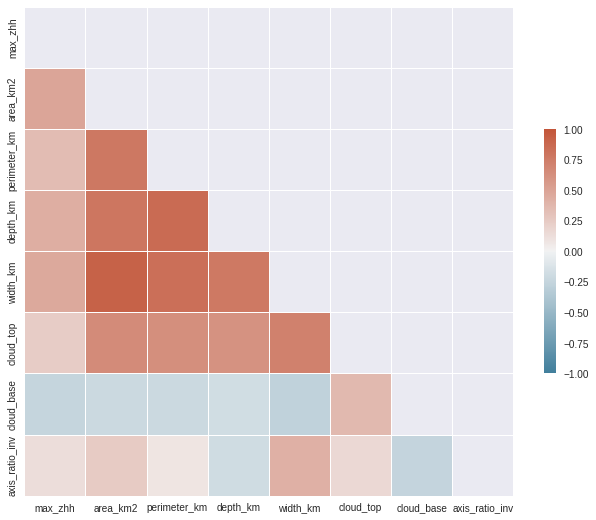

In [28]:
df_subset = zhh14[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo']]

corr = df_subset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
df_all_pos = df_all[df_all.vel >0]
df_all_neg = df_all[df_all.vel < 0]

In [30]:
# df_all_neg[df_all_pos.Location == 3]

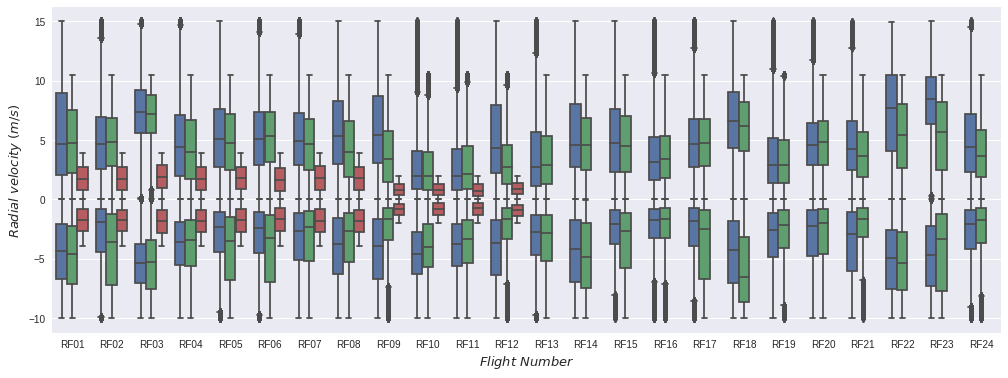

In [31]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'13'}
fig, ax = plt.subplots( figsize=(17, 6))
ax1 = sns.boxplot(x='vuelo', y='vel', hue='Location',data=df_all_pos, ax=ax)
ax2 = sns.boxplot(x='vuelo', y='vel', hue='Location',data=df_all_neg, ax=ax)
ax2.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Radial \ velocity \ (m/s)$', **axis_font)
# ax.set_ylim(0, 11)
legend_label = ["Ku-band", "Ka-band", "W-band"]
# ax1 .legend()


In [32]:
upd = updraft_percentiles.unstack(level=1)
upd['vuelo'] = upd.index
upd = upd.melt('vuelo', var_name='Percentile', value_name='vals')

In [33]:
dpd = downdraft_percentiles.unstack(level=1)
dpd['vuelo'] = dpd.index
dpd = dpd.melt('vuelo', var_name='Percentile', value_name='vals')


In [34]:
from matplotlib import pyplot


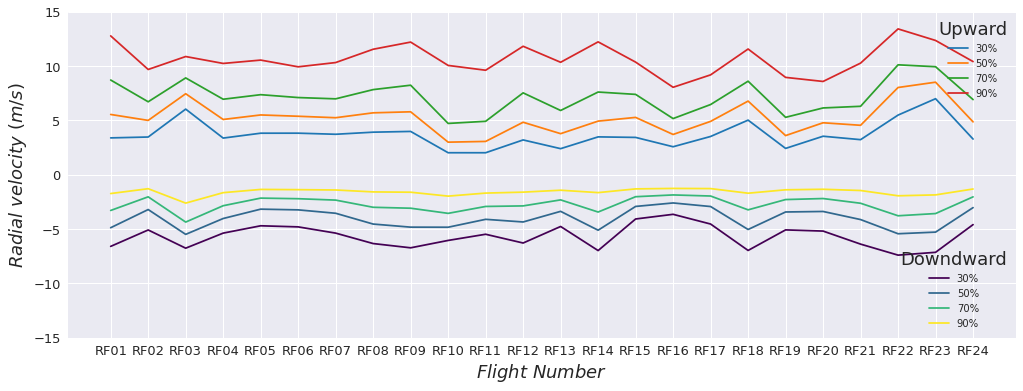

In [35]:
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Radial \ velocity \ (m/s)$', **axis_font)
ax.set_ylim(-15, 15)
ax1 = sns.lineplot(data=upd, x='vuelo', y='vals', hue='Percentile', ax=ax,  palette="tab10")
ax2 = [sns.lineplot(data=dpd, x='vuelo', y='vals', hue='Percentile', ax=ax, palette="viridis")]

handles, labels = ax.get_legend_handles_labels()
legend1 = pyplot.legend(handles=handles[:4], title='Upward', loc='upper right')


legend_label = ["30%", "50%", "70%", "90%"]
for n, i in enumerate(legend_label):
    ax.legend_.texts[n].set_text(i)

    
legend2 = pyplot.legend(handles=handles[4:], title='Downdward', loc='lower right')

legend_label = ["30%", "50%", "70%", "90%"]
for n, i in enumerate(legend_label):
    ax.legend_.texts[n].set_text(i)

ax.add_artist(legend1)
# ax.add_artist(legend2)
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
plt.show()
fig.savefig('../results/df_filtered/velocity.jpg', bbox_inches="tight", dpi=300)


<AxesSubplot:>

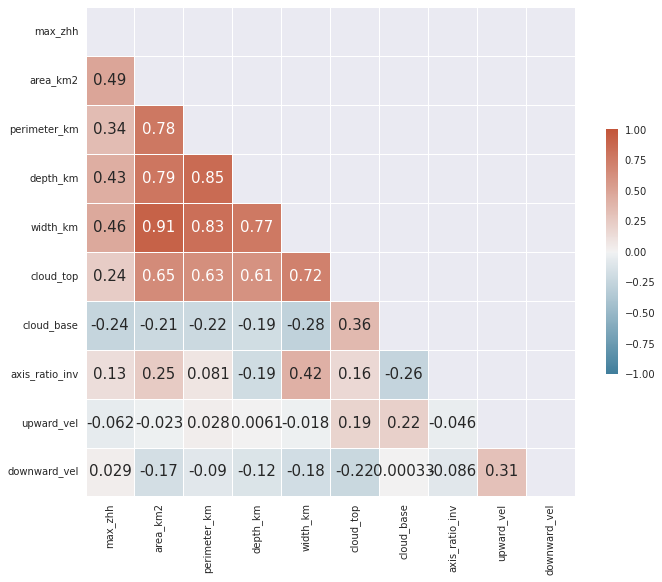

In [36]:
upward14 = df_14[df_14.vel > 0].groupby(['day'], as_index=False).mean()
downward14 = df_14[df_14.vel < 0].groupby(['day'], as_index=False).mean()

upward_dict = {row['day']: row['vel'] for index, row in upward14.iterrows()}
downward_dict = {row['day']: row['vel'] for index, row in downward14.iterrows()}

zhh14['upward_vel'] = zhh14['day'].map(upward_dict)
zhh14['downward_vel'] = zhh14['day'].map(downward_dict)

df_subset = zhh14[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo', 'upward_vel', 'downward_vel']]

corr = df_subset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.rcParams.update({'font.size': 15})
axis_font = {'size':'18'}
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

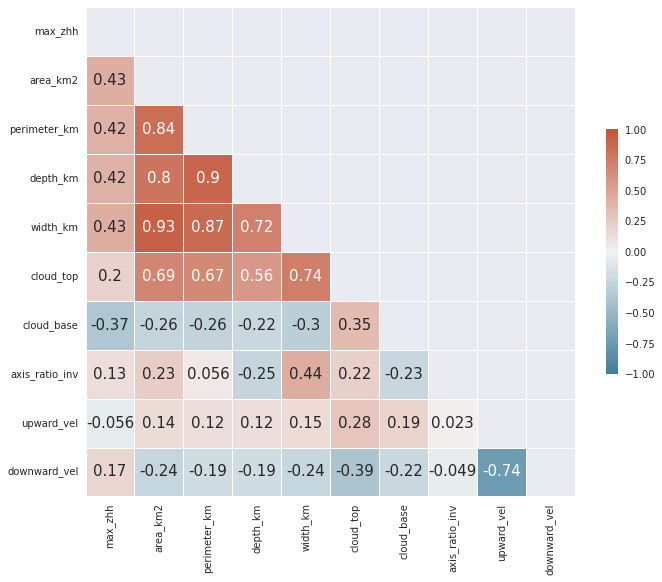

In [37]:
upward35 = df_35[df_35.vel > 0].groupby(['day'], as_index=False).mean()
downward35 = df_35[df_35.vel < 0].groupby(['day'], as_index=False).mean()

upward_dict = {row['day']: row['vel'] for index, row in upward35.iterrows()}
downward_dict = {row['day']: row['vel'] for index, row in downward35.iterrows()}

zhh35['upward_vel'] = zhh35['day'].map(upward_dict)
zhh35['downward_vel'] = zhh35['day'].map(downward_dict)

df_subset = zhh35[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo', 'upward_vel', 'downward_vel']]

corr35 = df_subset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.rcParams.update({'font.size': 15})
axis_font = {'size':'18'}
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr35, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

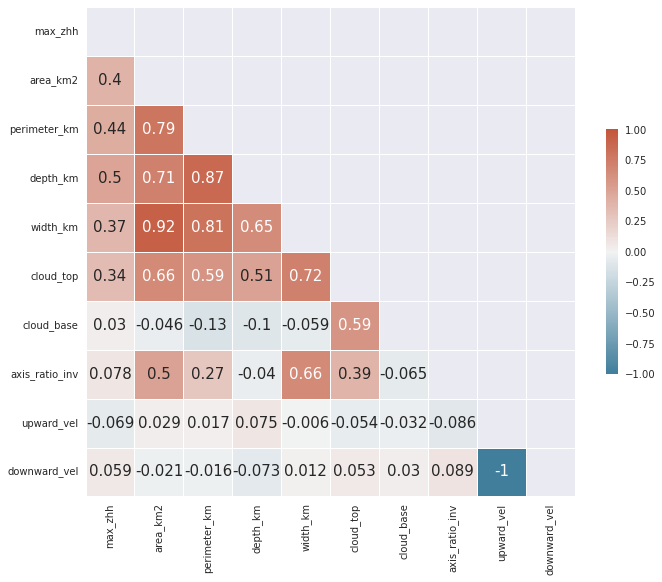

In [38]:
upward95 = df_95[df_95.vel > 0].groupby(['vuelo'], as_index=False, dropna=True).mean()
downward95 = df_95[df_95.vel < 0].groupby(['vuelo'], as_index=False, dropna=True).mean()

upward_dict = {row['vuelo']: row['vel'] for index, row in upward95.iterrows()}
downward_dict = {row['vuelo']: row['vel'] for index, row in downward95.iterrows()}

zhh95['upward_vel'] = zhh95['vuelo'].map(upward_dict)
zhh95['downward_vel'] = zhh95['vuelo'].map(downward_dict)

df_subset = zhh95[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo', 'upward_vel', 'downward_vel']]

corr95 = df_subset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.rcParams.update({'font.size': 15})
axis_font = {'size':'18'}
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr95, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

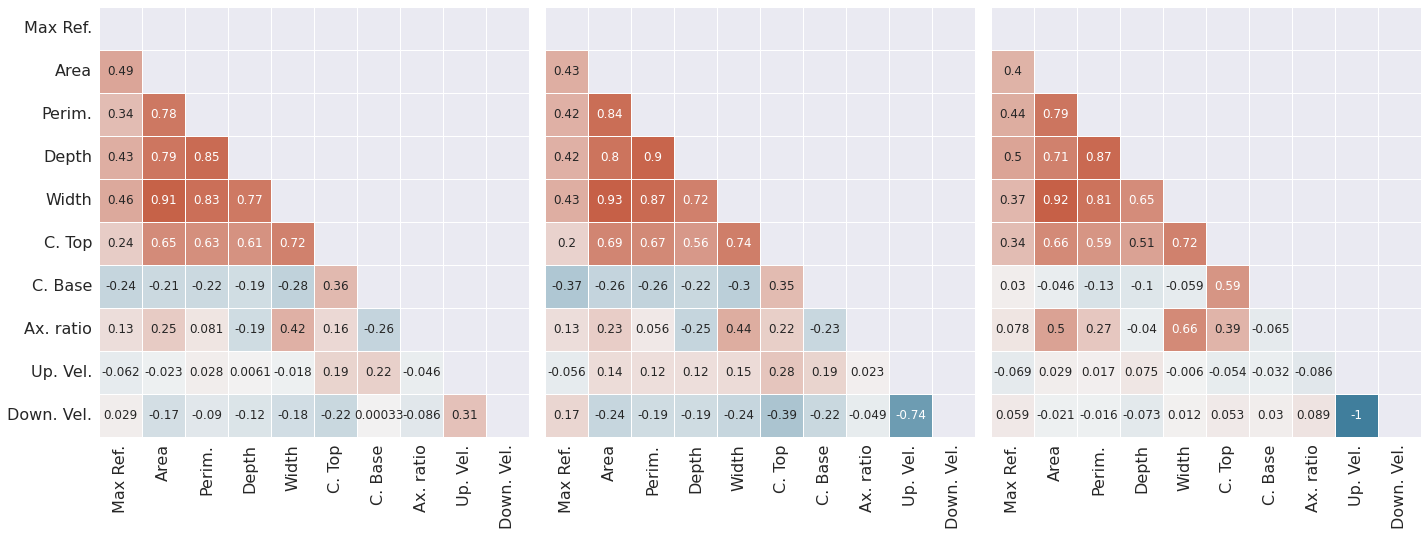

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12), sharey=True)
plt.rcParams.update({'font.size': 12})
axis_font = {'size':'16'}
title_font = {'size':'18'}
# ax1.set_title('Ku-band', **title_font)
# ax2.set_title('Ka-band', **title_font)
# ax3.set_title('W-band', **title_font)
new_labels = ["Max Ref.", "Area", "Perim.", "Depth", "Width", "C. Top", "C. Base", "Ax. ratio", "Up. Vel.", "Down. Vel."]
cor1 = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax1, cbar=False)
cor2 = sns.heatmap(corr35, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax2, cbar=False)
cor3 = sns.heatmap(corr95, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax3, cbar=False)
ax1.set_xticklabels(new_labels, **axis_font)
ax2.set_xticklabels(new_labels, **axis_font)
ax3.set_xticklabels(new_labels, **axis_font)
ax1.set_yticklabels(new_labels, **axis_font)
plt.tight_layout()
fig.savefig('../results/df_filtered/corr_matrix.jpg', bbox_inches="tight", dpi=300)
